In [1]:
# Basic Libraries: numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Lightkurve library aka the main thing that allows us to plot lightcurves
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import lightkurve as lk
%matplotlib inline

# Something to automate downloading pixel files (optional)
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Some more graphing/data organization library(s)
import pandas as pd

# W.I.P; trying to fit a curve to a star's lightcurve 
# to find out more information about the potential exoplanet
from astropy.modeling import models, fitting
from astroquery.vizier import Vizier
import scipy.optimize

## Utilizing lightkurve's database in conjunction with MAST

In [4]:
# Now to define what star we want to look at:
# I use MAST's Tess Input v8.x: https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

# Target's catalog name; let's look at Tabby's star
tess_target = 'TIC 185336364'
# Search lightkurve's database for our target's photometry data
# long cadence b/c I want to see "long term changes"
search = lk.search_targetpixelfile(target=tess_target, cadence='long')

# Returns a chart of the pixel files and some information along with them

In [5]:
# Now I want to specify what pixel file I want to work with, usually will choose 'TESS-SPOC' 
# if available and an arbitrary sector
pixelFile = lk.search_targetpixelfile(target=tess_target, author='TESS-SPOC', sector=15).download()
# A cool function that works in Jupyter notebooks that plots the raw lightcurve and pixel file
# You can use the sliders to see the change over time as well as stretch the pixel data
#pixelFile.interact()

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'vscode-webview://0865mulgt8a3enaugqi4hus6o7lc22ujtijei8np2a5dcahd3jgl';                       use --allow-websocket-origin=0865mulgt8a3enaugqi4hus6o7lc22ujtijei8np2a5dcahd3jgl or set BOKEH_ALLOW_WS_ORIGIN=0865mulgt8a3enaugqi4hus6o7lc22ujtijei8np2a5dcahd3jgl to permit this; currently we allow origins {'localhost:8888'}


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

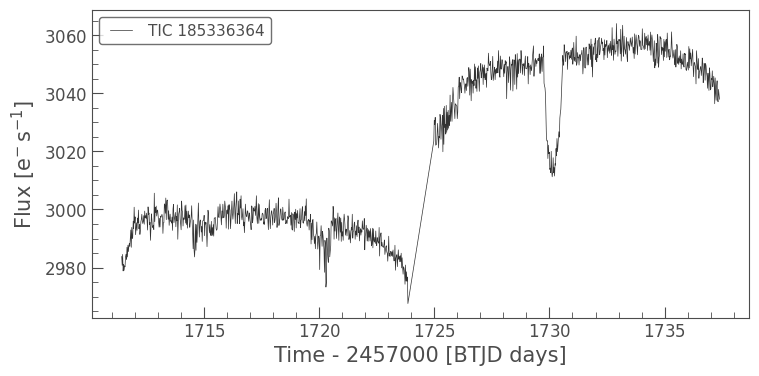

In [6]:
# Now, going to assign the data to "lc" and apply an aperature mask that "focuses" in on the object only;
# if the interact function works, you can see the mask as a white box around each pixel
# the default is pipeline, but you can create your own mask to select objects 
# next to the observed star or create thresholds on the one you're viewing
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

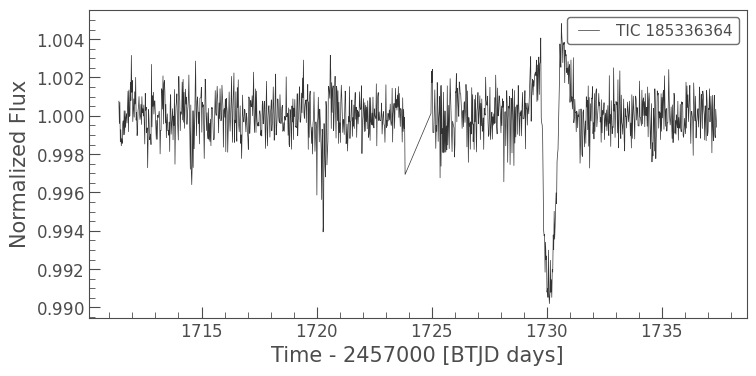

In [7]:
# a useful function from lightkurve that normalizes the data 
flat_lc = lc.flatten()
flat_lc.plot()

4.900990099009901 d
1715.4093989189491


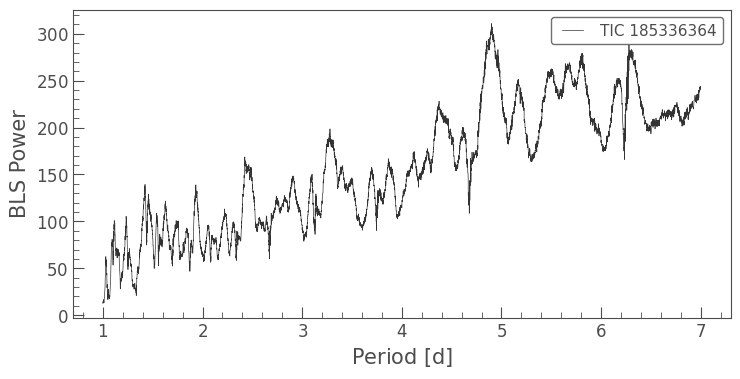

In [8]:
# Using the box least sqaure statistical method, we're going to plot a periodogram of our data 
# Can change the frequency factor, as well as the period
# Frequency factor: how much of a repetition in the data we are looking for
# period: assign a range of periods that the object might be located in
# sticking to a smaller range helps find planets close to their star
bls = flat_lc.to_periodogram(method='bls', period=np.linspace(1, 7, 10000), frequency_factor=500)
bls.plot()

# At the highest power out periodogram can find, assign the period of our potential object
# and time of transit
period = bls.period_at_max_power
t0 = bls.transit_time_at_max_power

print(period)
print(t0)

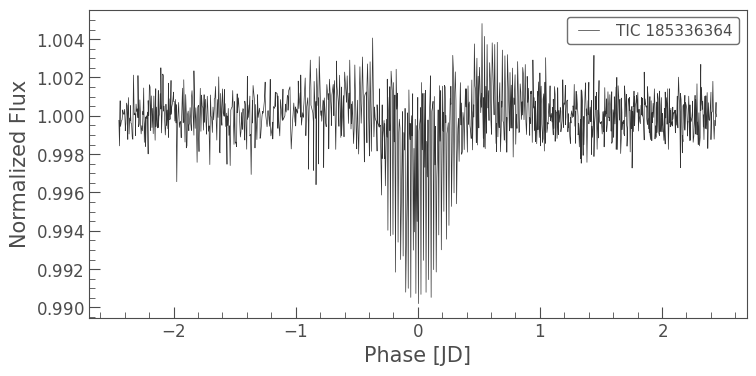

In [9]:
# Now, "fold" the data aka overlap each repitition onto each other to create the final lightcurve
folded_lc = flat_lc.fold(period=period, epoch_time=t0)
folded_lc.plot();

(-1.0, 1.0)

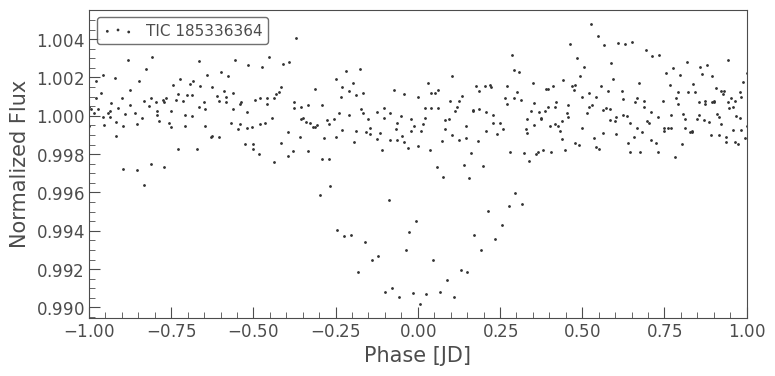

In [10]:
# Changing the graph to a scatter plot and adjusting plot limits
ax = flat_lc.fold(period=period, epoch_time=t0).scatter()
ax.set_xlim(-1,1)

(-1.0, 1.0)

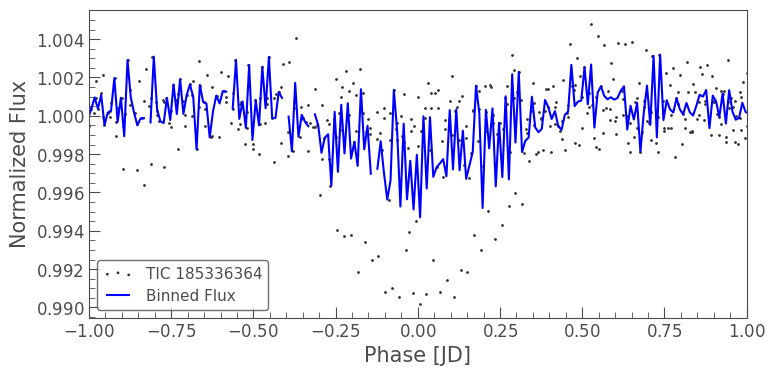

In [11]:
# This portion of code averages out each scatter and plots that average
ax = flat_lc.fold(period, t0).scatter()
flat_lc.fold(period, t0).bin(.01).plot(ax=ax, c='b', lw=1.5, label='Binned Flux')
ax.set_xlim(-1, 1)

Not the most exciting thing to look at, but if you stitch multiple instances together it looks pretty weird:


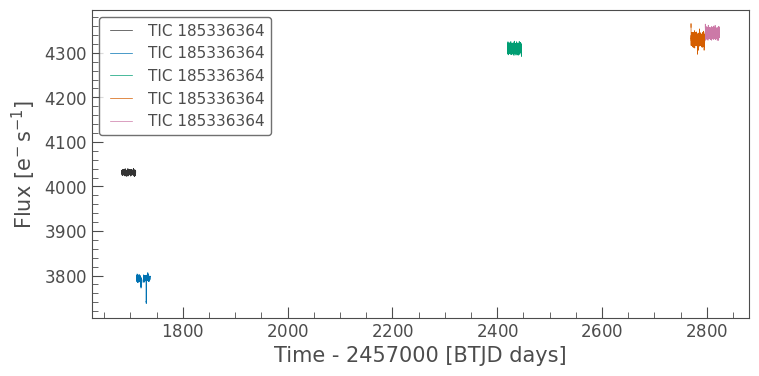

In [12]:
# A cool feature of lightkurve: instead of looking for the pixel file of an object,
# you can go directly to its lightcurve, if it has been already processed by the authors
search = lk.search_lightcurve('TIC 185336364', author='TESS-SPOC', cadence='long')
lc_collection = search.download_all()
ax = lc_collection[0].plot()
for lc in lc_collection[1:]:
    lc.plot(ax=ax)

## "Manual" method that downloads the pixel file using the 'product id' in MAST

In [ ]:
def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

# Get product group ID from MAST
product_group_id = "63411763"

# Don't have to change this, will just append link to the product id
url = "https://mast.stsci.edu/api/v0.1/Download/bundle.zip?previews=false&obsid=" + product_group_id

# Define destination to extract file to
destination = "C:/Users/mihir/python - research/exoplanets/"

download_and_unzip(url, destination)

In [7]:
tpf = TessTargetPixelFile('C:/Users/mihir/python - research/exoplanets/tic_stars/TIC405291867_tp.fits')
tpf.interact()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

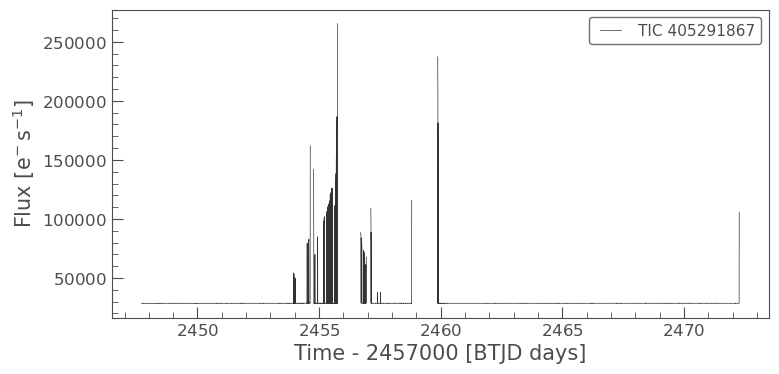

In [11]:
tpf_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
tpf_lc.plot()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

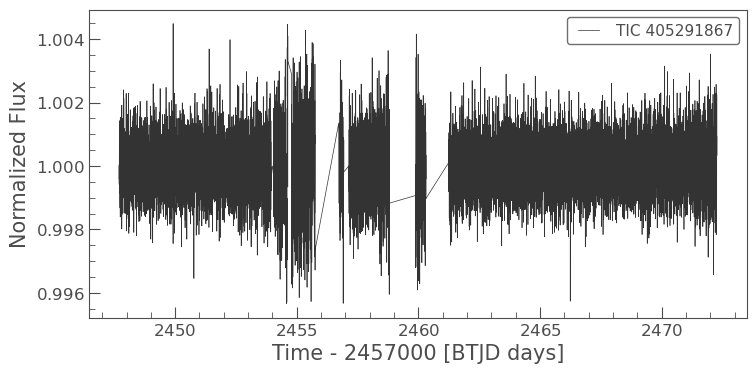

In [14]:
flat_lc = tpf_lc.flatten().remove_outliers()
flat_lc.plot()

2.7493749374937497 d
2449.075713990195


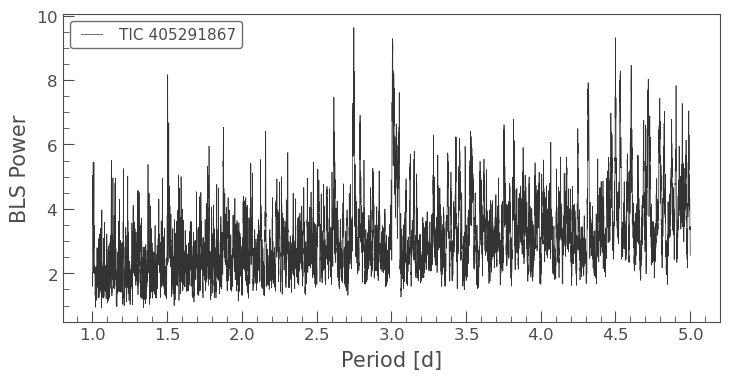

In [15]:
bls = flat_lc.to_periodogram(method ='bls', period=np.linspace(1, 5, 10000), frequency_factor=500)
bls.plot();

period = bls.period_at_max_power
t0 = bls.transit_time_at_max_power

print(period)
print(t0)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

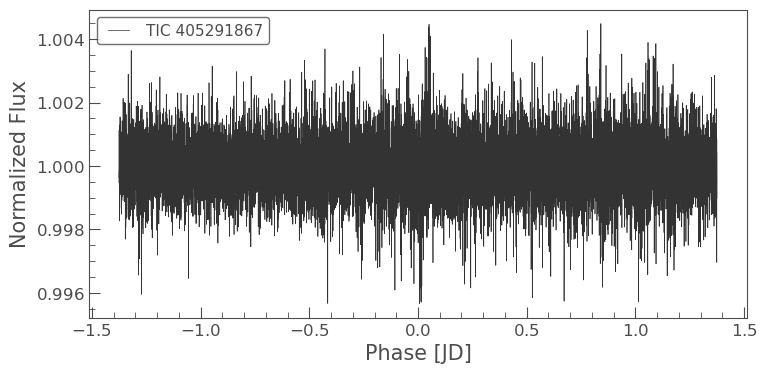

In [16]:
lc_fold = flat_lc.fold(period=period, epoch_time=t0)
lc_fold.plot()

(-1.0, 1.0)

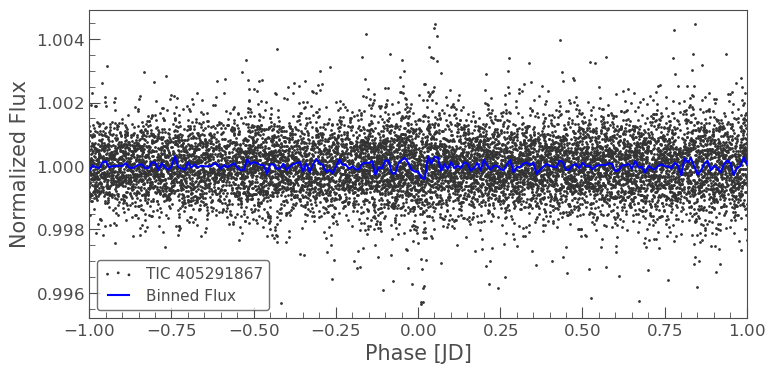

In [18]:
ax = flat_lc.fold(period, t0).scatter()
flat_lc.fold(period, t0).bin(.01).plot(ax=ax, c='b', lw=1.5, label='Binned Flux')
ax.set_xlim(-1, 1)

## Example of a known exoplanet candidate

In [13]:
# A target will have different names based on catalog, but since this is a more popular target,
# you can probably use whichever

tess_target = 'TOI-1338'
lk.search_targetpixelfile(target=tess_target, cadence='long')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TESS-SPOC,1800,260128333,0.0
1,TESS Sector 02,2018,TESS-SPOC,1800,260128333,0.0
2,TESS Sector 04,2018,TESS-SPOC,1800,260128333,0.0
3,TESS Sector 05,2018,TESS-SPOC,1800,260128333,0.0
4,TESS Sector 06,2018,TESS-SPOC,1800,260128333,0.0
5,TESS Sector 07,2019,TESS-SPOC,1800,260128333,0.0
6,TESS Sector 08,2019,TESS-SPOC,1800,260128333,0.0
7,TESS Sector 09,2019,TESS-SPOC,1800,260128333,0.0
8,TESS Sector 10,2019,TESS-SPOC,1800,260128333,0.0


4.867986798679868 d
1492.652469725257


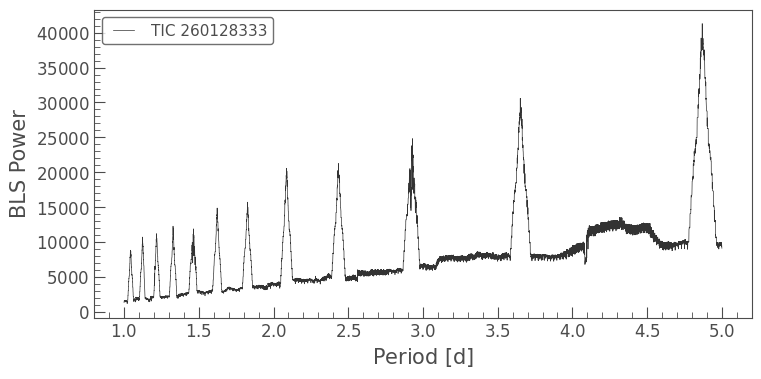

In [14]:
# A condensed version of the process, probably could condense it even more

pixelFile = lk.search_targetpixelfile(target=tess_target, author='TESS-SPOC', sector=7).download()
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
flat_lc = lc.flatten()
bls = flat_lc.to_periodogram(method='bls', period=np.linspace(1, 5, 10000), frequency_factor=500)
bls.plot()

period = bls.period_at_max_power
t0 = bls.transit_time_at_max_power

print(period)
print(t0)

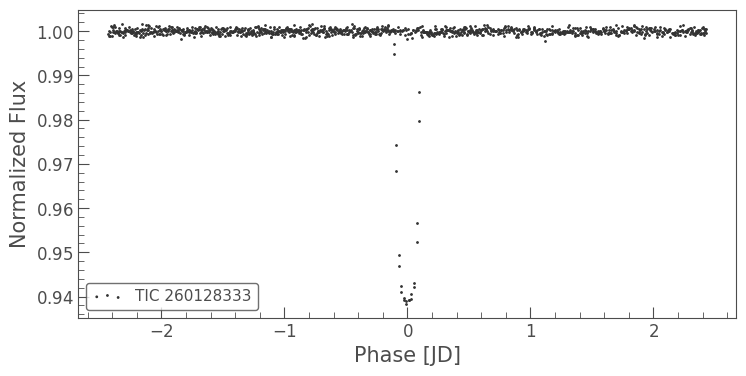

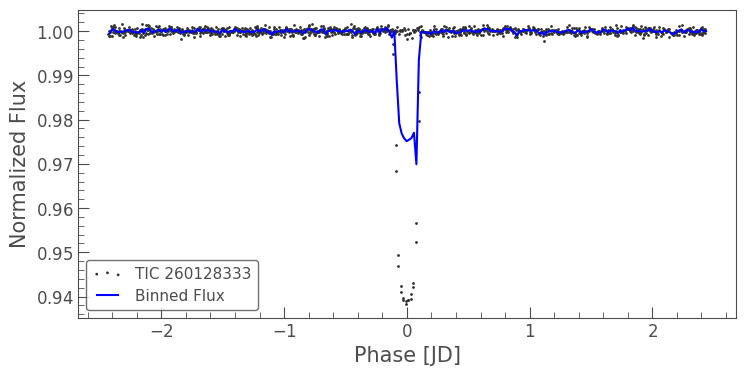

In [15]:
folded_lc = flat_lc.fold(period=period, epoch_time=t0).scatter()
ax = flat_lc.fold(period, t0).scatter()

# Can adjust the amount of bin, I tried to make it as perfect as possible, but there's not many data points
ax = flat_lc.fold(period, t0).bin(.02).plot(ax=ax, c='b', lw=1.5, label='Binned Flux')

# Main

In [3]:
target = 'TIC 422843808'
search = lk.search_targetpixelfile(target, mission='TESS')

ConnectTimeout: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Max retries exceeded with url: /portal/Mashup/Mashup.asmx/columnsconfig (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000242C7E375F0>, 'Connection to mast.stsci.edu timed out. (connect timeout=None)'))

<Axes: title={'center': 'Target ID: 422843808, Cadence: 175714'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

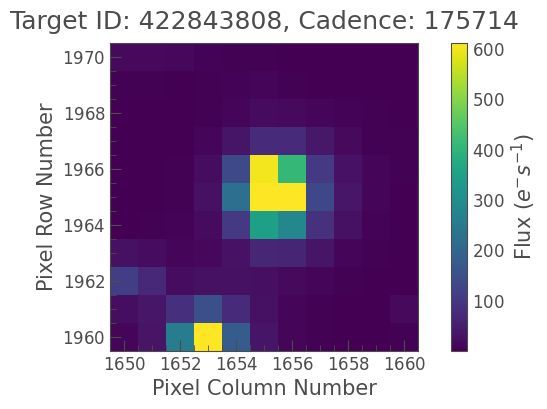

In [ ]:
tpf = lk.search_targetpixelfile(target, author='TESS-SPOC', sector='42').download()
tpf.plot()

<Axes: title={'center': 'Target ID: 422843808, Cadence: 175714'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

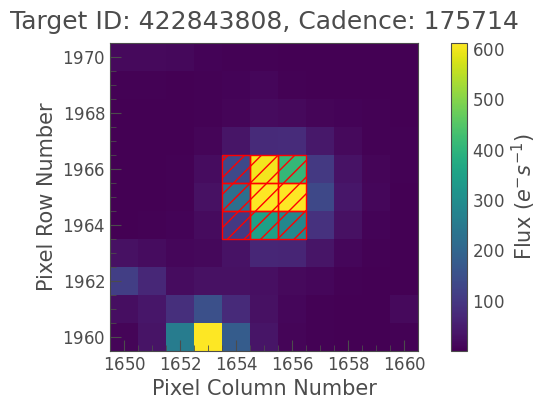

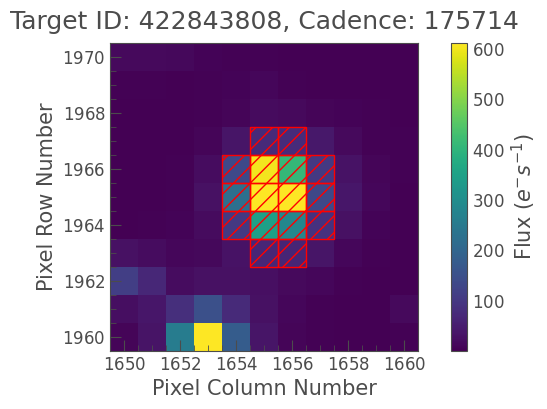

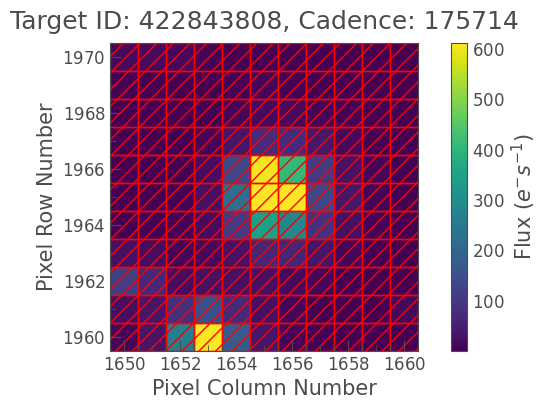

In [ ]:
tpf.plot(aperture_mask='pipeline')
tpf.plot(aperture_mask='threshold')
tpf.plot(aperture_mask='all')

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

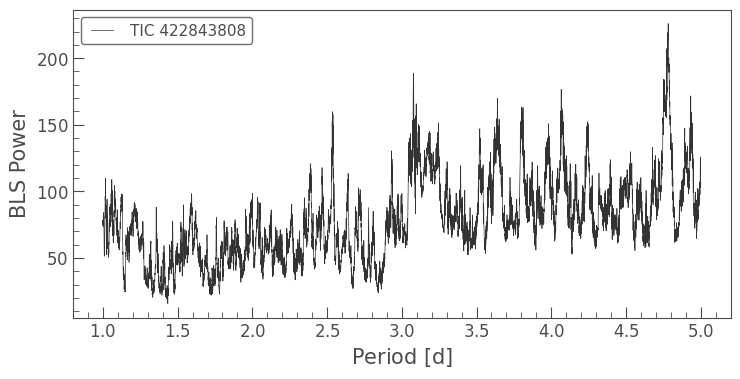

In [ ]:
lc = tpf.to_lightcurve(aperture_mask='all')
flat_lc = lc.flatten()

# Periodogram with best possible guess of period and frequency
bls = flat_lc.to_periodogram(method='bls', period=np.linspace(1, 5, 10000), frequency_factor=500)
bls.plot()

# Interact w/ the BLS to find planets
lc.interact_bls()

In [ ]:
period = bls.period_at_max_power
t0 = bls.transit_time_at_max_power

print(period)
print(t0)

4.7823782378237825 d
2452.182846173042


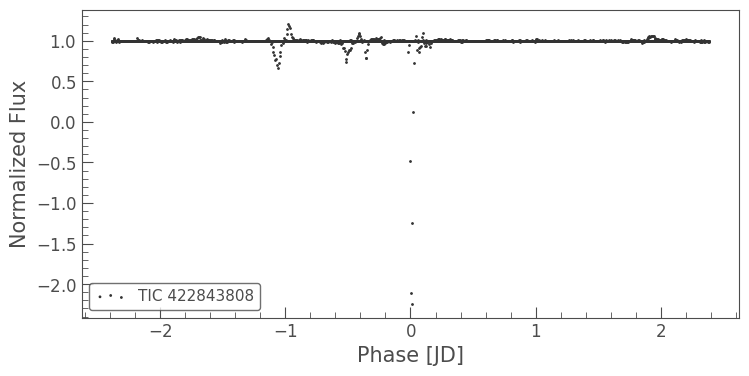

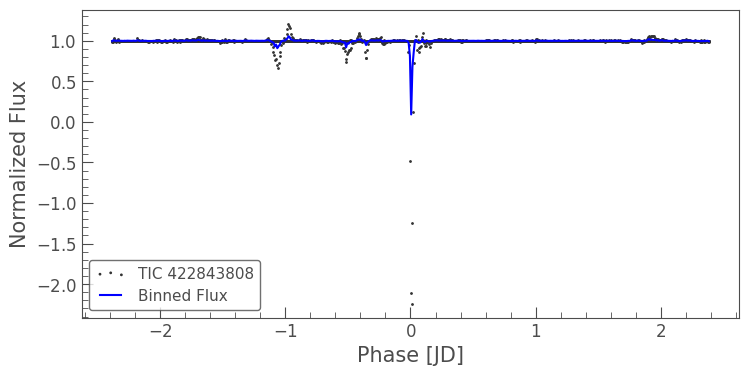

In [ ]:
folded_lc = flat_lc.fold(period=period, epoch_time=t0).scatter()
ax = flat_lc.fold(period, t0).scatter()

ax = flat_lc.fold(period, t0).bin(.01).plot(ax=ax, c='b', lw=1.5, label='Binned Flux')

folded_lc.plot_river()